<a href="https://colab.research.google.com/github/nischal1234/DS7010final/blob/main/Audio_DS7010_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Audio**

In [2]:
#library import
import pandas as pd
import numpy as np
import xgboost as xgb
import pickle
import matplotlib
import matplotlib.pyplot as plt
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.class_weight import compute_class_weight
import itertools
from IPython.display import display

%matplotlib inline

In [4]:
x_train = pd.read_csv('/content/drive/MyDrive/DS7010/emorec_data/s2e/audio_train.csv')
x_test = pd.read_csv('/content/drive/MyDrive/DS7010/emorec_data/s2e/audio_test.csv')

print(x_train.shape)
y_train = x_train['label']
y_test = x_test['label']

(7837, 10)


In [5]:
print(x_train.shape, x_test.shape)
cl_weight = dict(pd.Series(x_train['label']).value_counts(normalize=True))
print(dict(pd.Series(x_train['label']).value_counts()))

del x_train['label']
del x_test['label']
del x_train['wav_file']
del x_test['wav_file']

(7837, 10) (1960, 10)
{2: 2350, 5: 1343, 1: 1336, 3: 993, 4: 936, 0: 879}


In [6]:
emotion_dict = {'ang': 0,
                'hap': 1,
                'sad': 2,
                'fea': 3,
                'sur': 4,
                'neu': 5}

emo_keys = list(['ang', 'hap', 'sad', 'fea', 'sur', 'neu'])

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(y_test, pred_probs, cm=True):
    pred = np.argmax(pred_probs, axis=-1)
    one_hot_true = one_hot_encoder(y_test, len(pred), len(emotion_dict))
    print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.3f}'.format(f1_score(y_test, pred, average='macro')))
    print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred, average='macro')))
    print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred, average='macro')))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=emo_keys)

# **RF Classifier**

Test Set Accuracy =  0.571
Test Set F-score =  0.562
Test Set Precision =  0.582
Test Set Recall =  0.574
Confusion matrix, without normalization
[[ 74  40  87   3   6  14]
 [ 33  47 166   2   4  48]
 [ 26  54 427   2  17  57]
 [  0   0   0 247   0   0]
 [  0   0   0   0 241   0]
 [ 16  25 229   0  12  83]]


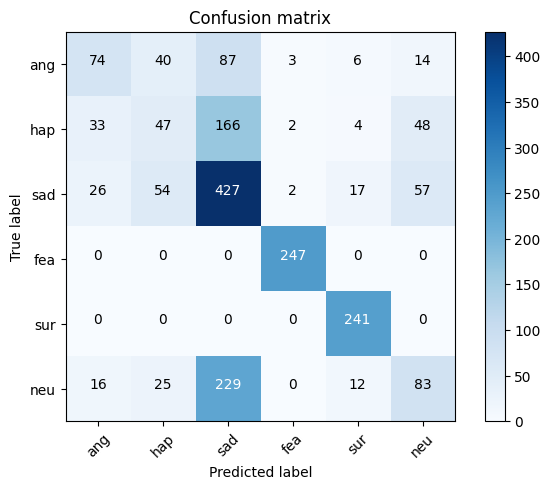

In [15]:
rf_classifier = RandomForestClassifier(n_estimators=1200, min_samples_split=30)
rf_classifier.fit(x_train, y_train)

# Predict
pred_probs = rf_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('/content/drive/MyDrive/DS7010/saved_pickle/rf_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

# **Logistic Regression**

Test Set Accuracy =  0.323
Test Set F-score =  0.151
Test Set Precision =  0.190
Test Set Recall =  0.212
Confusion matrix, without normalization
[[ 58  15 151   0   0   0]
 [ 17  16 267   0   0   0]
 [ 12  12 559   0   0   0]
 [  0   0 247   0   0   0]
 [ 23   1 217   0   0   0]
 [  6   5 354   0   0   0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


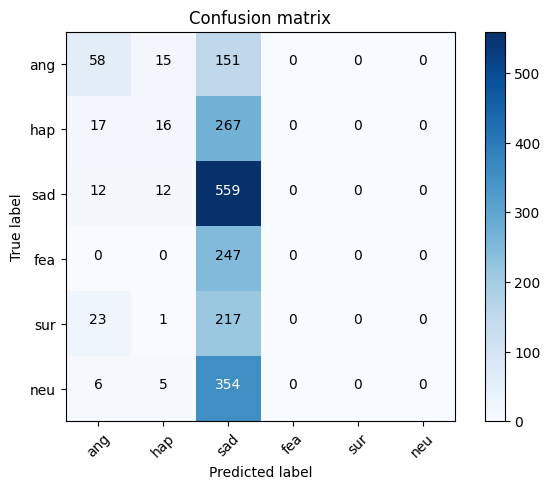

In [16]:
lr_classifier = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)

lr_classifier.fit(x_train, y_train)

# Predict
pred_probs = lr_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('/content/drive/MyDrive/DS7010/saved_pickle/lr_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

# **Extreme Gradient Boosting**

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [13:56:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)


Test Set Accuracy =  0.566
Test Set F-score =  0.569
Test Set Precision =  0.582
Test Set Recall =  0.575
Confusion matrix, without normalization
[[ 68  46  78   5   5  22]
 [ 37  63 141   0   3  56]
 [ 24  70 400   3  10  76]
 [  0   0   0 247   0   0]
 [  0   0   0   0 241   0]
 [ 18  33 218   1   4  91]]


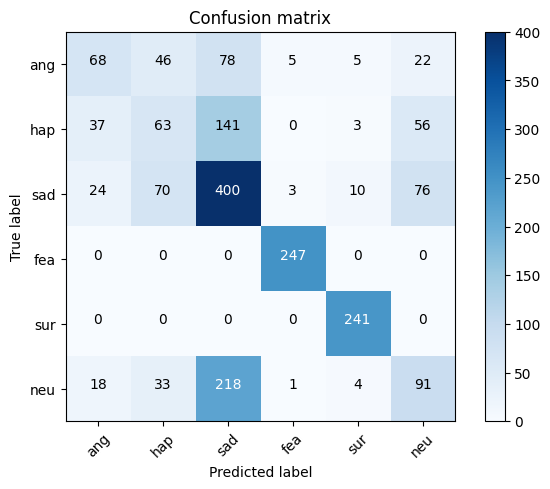

In [17]:
xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.008, objective='multi:softprob',
                                   n_estimators=1200, sub_sample=0.8, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(x_train, y_train)

# Predict
pred_probs = xgb_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('/content/drive/MyDrive/DS7010/saved_pickle/xgb_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

# **LSTM**

In [ ]:
import torch
import sys
import pickle
import numpy as np
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from utils import load_data, evaluate, plot_confusion_matrix

from config import model_config as config


class LSTMClassifier(nn.Module):
    """docstring for LSTMClassifier"""
    def __init__(self, config):
        super(LSTMClassifier, self).__init__()
        self.n_layers = config['n_layers']
        self.input_dim = config['input_dim']
        self.hidden_dim = config['hidden_dim']
        self.output_dim = config['output_dim']
        self.bidirectional = config['bidirectional']
        self.dropout = config['dropout'] if self.n_layers > 1 else 0

        self.rnn = nn.LSTM(self.input_dim, self.hidden_dim, bias=True,
                           num_layers=2, dropout=self.dropout,
                           bidirectional=self.bidirectional)
        self.out = nn.Linear(self.hidden_dim, self.output_dim)
        self.softmax = F.softmax

    def forward(self, input_seq):
        # input_seq =. [1, batch_size, input_size]
        rnn_output, (hidden, _) = self.rnn(input_seq)
        if self.bidirectional:  # sum outputs from the two directions
            rnn_output = rnn_output[:, :, :self.hidden_dim] +\
                        rnn_output[:, :, self.hidden_dim:]
        class_scores = F.softmax(self.out(rnn_output[0]), dim=1)
        return class_scores


if __name__ == '__main__':
    emotion_dict = {'ang': 0, 'hap': 1, 'sad': 2, 'fea': 3, 'sur': 4, 'neu': 5}

    device = 'cuda:{}'.format(config['gpu']) if \
             torch.cuda.is_available() else 'cpu'

    model = LSTMClassifier(config)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])

    train_batches = load_data()
    test_pairs = load_data(test=True)

    best_acc = 0
    for epoch in range(config['n_epochs']):
        losses = []
        for batch in train_batches:
            inputs = batch[0].unsqueeze(0)  # frame in format as expected by model
            targets = batch[1]
            inputs = inputs.to(device)
            targets = targets.to(device)

            model.zero_grad()
            optimizer.zero_grad()

            predictions = model(inputs)
            predictions = predictions.to(device)

            loss = criterion(predictions, targets)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        # evaluate
        with torch.no_grad():
            inputs = test_pairs[0].unsqueeze(0)
            targets = test_pairs[1]

            inputs = inputs.to(device)
            targets = targets.to(device)

            predictions = torch.argmax(model(inputs), dim=1)  # take argmax to get class id
            predictions = predictions.to(device)

            # evaluate on cpu
            targets = np.array(targets.cpu())
            predictions = np.array(predictions.cpu())

            # Get results
            # plot_confusion_matrix(targets, predictions,
            #                       classes=emotion_dict.keys())
            performance = evaluate(targets, predictions)
            if performance['acc'] > best_acc:
                best_acc = performance['acc']
                print(performance)
                # save model and results
                torch.save({
                    'model': model.state_dict(),
                    'optimizer': optimizer.state_dict()
                    }, 'runs/{}-best_model.pth'.format(config['model_code']))

                with open('results/{}-best_performance.pkl'.format(config['model_code']), 'wb') as f:
                    pickle.dump(performance, f)

# **MLP**

Test Set Accuracy =  0.399
Test Set F-score =  0.360
Test Set Precision =  0.445
Test Set Recall =  0.348
Confusion matrix, without normalization
[[ 65  33 104   7  12   3]
 [ 21  50 179   9   7  34]
 [ 20  38 428  36  12  49]
 [  0   0 121 113   9   4]
 [ 15   9 125  21  67   4]
 [  8  18 240  25  15  59]]


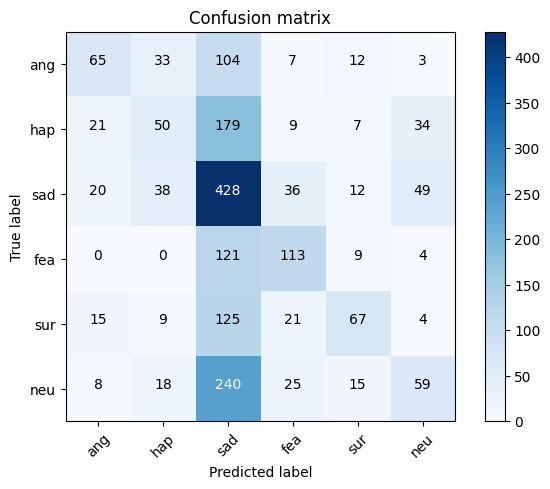

In [18]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(650, ), activation='relu', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='adaptive', learning_rate_init=0.01,
                               power_t=0.5, max_iter=1000, shuffle=True, random_state=None, tol=0.0001,
                               verbose=False, warm_start=True, momentum=0.8, nesterovs_momentum=True,
                               early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999,
                               epsilon=1e-08)

mlp_classifier.fit(x_train, y_train)

# Predict
pred_probs = mlp_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('/content/drive/MyDrive/DS7010/saved_pickle/mlp_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

# **ensemble learning**

Test Set Accuracy =  0.569
Test Set F-score =  0.562
Test Set Precision =  0.595
Test Set Recall =  0.570
Confusion matrix, without normalization
[[ 76  30  96   5   5  12]
 [ 30  51 173   0   4  42]
 [ 24  49 440   5   8  57]
 [  0   0   0 247   0   0]
 [  0   0   8   0 233   0]
 [ 11  23 255   0   8  68]]


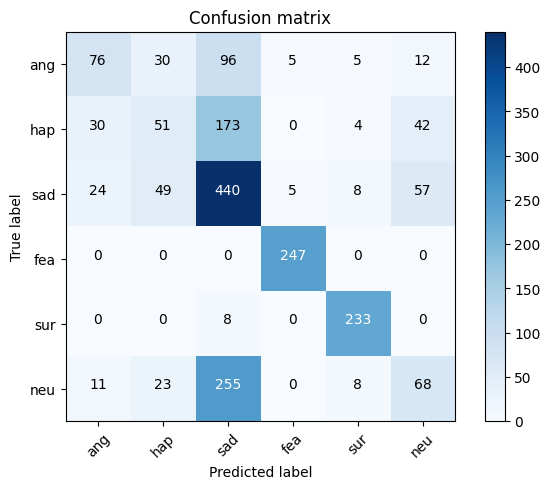

In [19]:
# Load predicted probabilities
with open('/content/drive/MyDrive/DS7010/saved_pickle/rf_classifier.pkl', 'rb') as f:
    rf_pred_probs = pickle.load(f)

with open('/content/drive/MyDrive/DS7010/saved_pickle/xgb_classifier.pkl', 'rb') as f:
    xgb_pred_probs = pickle.load(f)


with open('/content/drive/MyDrive/DS7010/saved_pickle/mlp_classifier.pkl', 'rb') as f:
    mlp_pred_probs = pickle.load(f)

with open('/content/drive/MyDrive/DS7010/saved_pickle/lr_classifier.pkl', 'rb') as f:
    lr_pred_probs = pickle.load(f)

# Average of the predicted probabilites
ensemble_pred_probs = (xgb_pred_probs +
                       mlp_pred_probs +
                       rf_pred_probs)/3.0
# Show metrics
display_results(y_test, ensemble_pred_probs)